# Lecture 2. 신경망의 수학적 이해
* Ref. 최건호, 파이토치 첫걸음, 한빛미디어

## 1. Framework 비교
* 선형 연산 (linear operation): y = W * x + z (W: kernel, z: bias)
* 속도 비교: Numpy vs Tensorflow vs Pytorch

In [1]:
import numpy as np 
import tensorflow as tf
import torch
from datetime import datetime

2023-04-12 21:02:11.322064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 21:02:12.047239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 연산에 필요한 numpy, 시간을 측정하기 위해 datetime을 불러옵니다.
start = datetime.now()

# 랜덤하게 3x4 형태의 변수 x,y,z를 설정해줍니다.
np.random.seed(0)

N,D = 3,4

x = np.random.randn(N,D)
w = np.random.randn(N,D)
z = np.random.randn(N,D)

# x,y,z를 이용해 x*y+z를 계산해줍니다.
a = x * w
b = a + z
c = np.sum(b)

# 기울기(gradient)가 1이라고 가정하고 역전파를 해줍니다. 역전파에 대한 내용은 4장에서 자세히 다룹니다.
grad_c = 1.0
grad_b = grad_c * np.ones((N,D))
grad_a = grad_b.copy()
grad_z = grad_b.copy()
grad_w = grad_a * w
grad_x = grad_a * x

# 각각의 기울기가 몇인지 걸린 시간은 얼마인지 확인해봅니다.
print('gradient x = ', grad_x)
print('gradient W = ', grad_w)
print('gradient z = ', grad_z)
print('# Operation Time = ', datetime.now()-start)

gradient x =  [[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]
gradient W =  [[ 0.76103773  0.12167502  0.44386323  0.33367433]
 [ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]]
gradient z =  [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
# Operation Time =  0:00:00.001710


In [3]:
# 이번에는 텐서플로 프레임워크를 이용해 같은 연산을 해보도록 하겠습니다.
start = datetime.now()
gpu_num = 0 # 일반적으로 0번이지만, 자신의 환경에 맞게 설정

# 텐서플로는 연산 그래프를 먼저 정의하고 추후에 여기에 값을 전달하는 방식입니다. 여기서는 비어있는 그래프만 정의해줍니다.
# Define Graph on GPU
with tf.device(f'/gpu:{gpu_num}'):              # 해당 연산을 위에서 지정한 gpu에서 하겠다는 의미입니다.
    tf.random.set_seed(0)

    N,D = 3,4
    
    x = tf.Variable(tf.random.uniform(shape=(N,D)), dtype=tf.float32)
    w = tf.Variable(tf.random.uniform(shape=(N,D)), dtype=tf.float32)
    z = tf.Variable(tf.random.uniform(shape=(N,D)), dtype=tf.float32)

    with tf.GradientTape() as tape:        # 텐서플로의 경우 계산 그래프에서 작동합니다.
        a = x * w                          # 연산 과정 또한 정의해줍니다.
        b = a + z
        c = tf.reduce_sum(b)
        [grad_x, grad_w, grad_z] = tape.gradient(c,[x,w,z])  # c에 대한 x,y,z의 기울기(gradient)를 구하고 이를 각각 grad_x, grad_y, grad_z에 저장하도록 지정해놓습니다.

# 값들을 확인하고 걸린 시간을 측정합니다.
print('gradient x = ', grad_x)
print('gradient W = ', grad_w)
print('gradient z = ', grad_z)
print('# Operation Time = ', datetime.now()-start)

gradient x =  tf.Tensor(
[[0.5554141  0.22129297 0.8649249  0.77728355]
 [0.6451167  0.53036225 0.01444101 0.87350917]
 [0.4697218  0.38672888 0.88615394 0.6367892 ]], shape=(3, 4), dtype=float32)
gradient W =  tf.Tensor(
[[0.29197514 0.20656645 0.53539073 0.5612575 ]
 [0.4166745  0.80782795 0.4932251  0.99812925]
 [0.69673514 0.1253736  0.7098167  0.6624156 ]], shape=(3, 4), dtype=float32)
gradient z =  tf.Tensor(
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]], shape=(3, 4), dtype=float32)
# Operation Time =  0:00:05.257465


2023-04-12 21:02:23.034628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11122 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2
2023-04-12 21:02:23.035312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11133 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:06:00.0, compute capability: 5.2
2023-04-12 21:02:23.035830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11133 MB memory:  -> device: 2, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:09:00.0, compute capability: 5.2
2023-04-12 21:02:23.036361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11133 MB memory:  -> device: 3, name: NVIDIA GeForce

In [4]:
# 이번에는 파이토치를 이용해 같은 연산을 진행해보도록 하겠습니다.
from datetime import datetime
start = datetime.now()
gpu_num = 0 # 일반적으로 0번이지만, 자신의 환경에 맞게 설정

N,D = 3,4

# x,y,z를 랜덤하게 초기화 해줍니다. 
# https://pytorch.org/docs/stable/torch.html?highlight=randn#torch.randn

x = torch.randn(N,D,device=torch.device(f'cuda:{gpu_num}'), requires_grad=True)
w = torch.randn(N,D,device=torch.device(f'cuda:{gpu_num}'), requires_grad=True)
z = torch.randn(N,D,device=torch.device(f'cuda:{gpu_num}'), requires_grad=True)

# 연산 그래프는 정의됨과 동시에 연산됩니다.
a = x * w
b = a + z
c = torch.sum(b)

# 역전파 실행 (Numpy에서는 해당 과정을 직접 풀어서 작성하였다)
c.backward()


# 각각의 기울기와 걸린 시간을 출력합니다.
print('gradient x = ', grad_x)
print('gradient W = ', grad_w)
print('gradient z = ', grad_z)
print('# Operation Time = ', datetime.now()-start)

gradient x =  tf.Tensor(
[[0.5554141  0.22129297 0.8649249  0.77728355]
 [0.6451167  0.53036225 0.01444101 0.87350917]
 [0.4697218  0.38672888 0.88615394 0.6367892 ]], shape=(3, 4), dtype=float32)
gradient W =  tf.Tensor(
[[0.29197514 0.20656645 0.53539073 0.5612575 ]
 [0.4166745  0.80782795 0.4932251  0.99812925]
 [0.69673514 0.1253736  0.7098167  0.6624156 ]], shape=(3, 4), dtype=float32)
gradient z =  tf.Tensor(
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]], shape=(3, 4), dtype=float32)
# Operation Time =  0:00:00.055343


## 2. 텐서 연산
* 텐서 생성 (Tensor Creation)
* 기울기 계산 (Gradient Operation)
* 인퍼런스 (Inference)

### 2.1. 토치 텐서

In [2]:
import torch
x_rand = torch.Tensor(2,3) # 난수 생성
x_data = torch.Tensor([[1,2,3],[4,5,6]]) # 데이터 지정
print(x_rand)
print(x_data)

tensor([[-1.3104e+27,  4.5588e-41, -1.3104e+27],
        [ 4.5588e-41,  5.0000e+00,  6.0000e+00]])
tensor([[1., 2., 3.],
        [4., 5., 6.]])


* Torch Tensor 사용법
    *   Ref link (파이토치 홈페이지): https://pytorch.org/docs/stable/tensors.html?highlight=torch+tensor#torch.Tensor

In [13]:
data_arr = [[1,2,3],[4,5,6]]
x_tensor = torch.tensor(data=data_arr,   # 텐서로 변환시킬 데이터 행렬
                        dtype=torch.float32,    # 토치 타입
                        device=torch.device('cuda:0'),    # 저장할 디바이스 (CPU vs GPU)
                        requires_grad=True)     # 계산한 기울기 저장 여부

# GPU 텐서를 바로 생성할 수도 있다 (Data type도 float으로 미리 설정).
y_tensor = torch.cuda.FloatTensor([1,2,3]) 
print(x_tensor)
print(y_tensor)

tensor([[1., 2., 3.],
        [4., 5., 6.]], device='cuda:0', requires_grad=True)
tensor([1., 2., 3.], device='cuda:0')


In [9]:
# 파이토치에서 GPU 사용은 핵심이다. 아래의 코드로 사용가능한 GPU를 확인가능하다!
import os, torch

print("사용 가능한 GPU가 존재하는가? (True or False): ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 가능한 GPU의 수는 {} 개 입니다.".format(torch.cuda.device_count()))
    print("GPU 각각의 이름은 아래와 같습니다.")
    for i in range(torch.cuda.device_count()):
        print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Pytorch가 찾지 못하고 있습니다.")

사용 가능한 GPU가 존재하는가? (True or False):  True
사용 가능한 GPU의 수는 4 개 입니다.
GPU 각각의 이름은 아래와 같습니다.
GPU 0: NVIDIA GeForce GTX TITAN X
GPU 1: NVIDIA GeForce GTX TITAN X
GPU 2: NVIDIA GeForce GTX TITAN X
GPU 3: NVIDIA GeForce GTX TITAN X


### 2.2. 기울기 계산

* requires_grad를 True로 활성화 시킬 경우 기울기 계산이 가능하다.

In [7]:
# 텐서 생성
x = torch.tensor([1.,2.,3.],requires_grad=True)
y = torch.tensor([2.,3.,4.],requires_grad=True)
print(x)
print(y)

# 기울기 계산
z = x + y
z.sum().backward()

tensor([1., 2., 3.], requires_grad=True)
tensor([2., 3., 4.], requires_grad=True)


* 간단한 연산의 역전파 (z = 2x<sup>2</sup> + 3)

In [17]:
# 텐서 생성 및 선형 연산
x = torch.tensor(data=[2.0,3.0],requires_grad=True)
y = x**2
z = 2*y +3

# 목표값을 지정합니다. 
target = torch.tensor([3.0,4.0])

# z와 목표값의 절대값 차이를 계산합니다. 
# backward는 스칼라 값에 대해서 동작하기 때문에 길이 2짜리 텐서인 loss를 torch.sum을 통해 하나의 숫자로 바꿔줍니다.
loss = torch.sum(torch.abs(z-target))

# 그리고 스칼라 값이 된 loss에 대해 backward를 적용합니다.
loss.backward()

# 여기서 y와 z는 기울기가 None으로 나오는데 이는 x,y,z중에 x만이 leaf node이기 때문입니다.
print('* gradient = ', x.grad, y.grad, z.grad)
print('* 손실값 = ', loss)

* gradient =  tensor([ 8., 12.]) None None
* 손실값 =  tensor(25., grad_fn=<SumBackward0>)


/tmp/ipykernel_30111/409920484.py:17: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print('* gradient = ', x.grad, y.grad, z.grad)


* 기울기 계산이 완료되었다면(즉 학습 완료!), 기울기 계산을 끄고 결과값만 추론할 수 있다.
* 학습완료된 모델을 사용하여, 새로운 예측값을 결과로 얻어내는 과정을 'inference'라고 부른다!
* no_grad()를 사용하면 기울기 계산을 끌 수 있다. (사실 신경망 모델에서는 model.eval()을 쓰면 된다! Lecture 4에서 배울 것이다!)

In [8]:
print(x.requires_grad,y.requires_grad)

with torch.no_grad():
    z = x + y
    print(z.requires_grad)

True True
False


## 3. 선형 회귀 분석 (linear regression analysis)
* 선형 모델 (Linear Model) : y = xA<sup>T</sup>+b (* 파이토치 API 참고)
* y = 2x + 3

### 3.1. 라이브러리 불러오기

In [1]:
# 넘파이와 파이토치를 불러옵니다.
import numpy as np
import torch

# Neural Network의 약자로 인공신경망 연산들이 들어가 있습니다. (ex. Linear, Convolution, RNN 등등)
import torch.nn as nn           

# 모델을 최적화 하는데 필요한 최적화 함수들이 들어가 있습니다 (ex. SGD, ADAM, LBFGS 등등)
import torch.optim as optim

# 텐서를 초기화 하는 함수들이 들어가 있습니다. (ex. uniform, normal, xavier 등등)
import torch.nn.init as init

# 데이터나 학습 결과를 출력하기 위해 사용합니다.
import matplotlib.pyplot as plt

### 3.2. 데이터 준비

In [14]:
# 데이터의 개수는 1000개, 학습 횟수는 500회로 지정해줍니다. 
# 이는 임의로 지정한 수치입니다.

num_data = 1000 
num_epoch = 500

# 데이터에 추가할 노이즈를 정규분포를 따르게 만들어줍니다. 
# 이때 평균은 디폴트로 0, 편차는 0.2로 임의로 지정했습니다.
noise = init.normal_(torch.FloatTensor(num_data,1),std=0.5)

# x 는 -10에서 10에서 uniform 하게 생성합니다. 
# 이렇게 되면 x는 1000x1 형태를 가지고 -10에서 10 사이의 값들을 uniform 하게 갖게 됩니다.
x = init.uniform_(torch.Tensor(num_data,1),-10,10)

# 연산 그래프를 정의합니다.
y = 2*x+3

# y에 노이즈를 더해 y_noise를 만들어줍니다. 
# 학습때 y_noise를 목표값으로 사용합니다.
# 이렇게 하는 이유는 실제 데이터를 사용할 때 여러 측정과정에서 노이즈가 추가되는 경우가 많기 때문입니다.
y_noise = y+noise

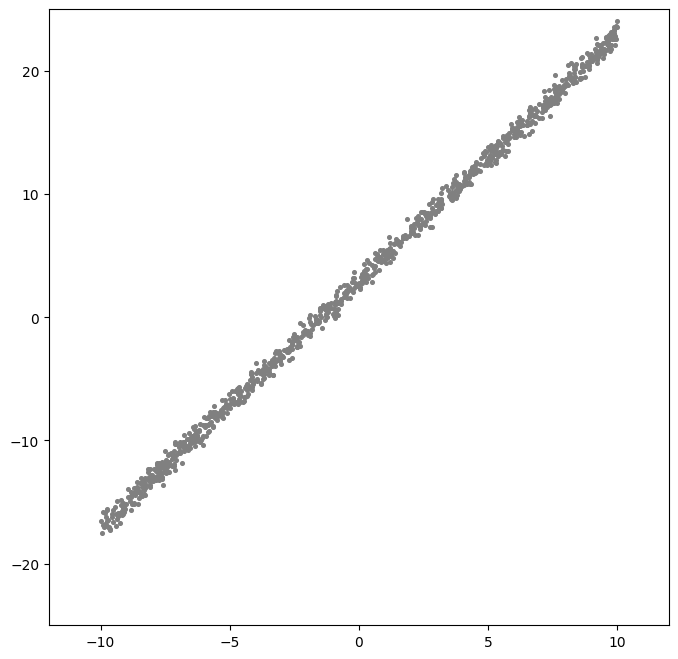

In [15]:
# matplotlib의 scatter 함수를 사용해 학습 데이터를 확인합니다.

# figure의 크기를 지정해줍니다.
plt.figure(figsize=(8,8))

# x축에는 x를 사용하고 y축에는 y_noise를 사용해 scatter plot 해줍니다.
# 이때 점의 크기는 7, 점의 색상은 회색으로 임의로 지정했습니다.
plt.scatter(x.numpy(),y_noise.numpy(),s=7,c="gray")

# figure의 x,y 축 범위를 지정해줍니다.
plt.axis([-12, 12, -25, 25])

# figure를 출력합니다.
plt.show()

### 3.3. Model 만들기

In [16]:
# 선형 모델을 생성합니다.
# 입력으로 들어오는 x가 1000x1 의 형태를 가지고 있고 여기서 특성의 개수는 1개이기 때문에 앞에 1이 들어가게 됩니다. Linear(1,?)
# 출력으로 기대하는 값 또한 1000x1 의 형태이기 때문에 특성의 개수가 1개. 그렇기 때문에 뒤에 1이 들어갑니다.      Linear(?,1)
model = nn.Linear(1,1)

# 손실 함수를 지정해줍니다.
# 임의로 L1 손실을 사용했습니다.
loss_func = nn.L1Loss()

# 최적화 함수를 지정해줍니다.
# 이때 인수로 학습의 대상이 되는 모델의 변수(model.parameters())를 전달합니다.
# 또한 학습률은 0.01로 임의로 지정했습니다.
optimizer = optim.SGD(model.parameters(),lr=0.01)

### 3.4. Model 학습하기

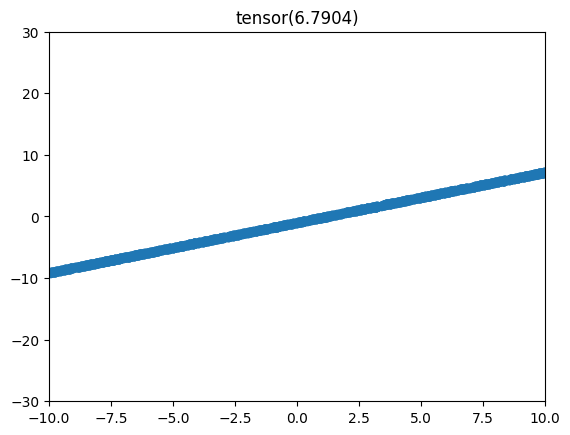

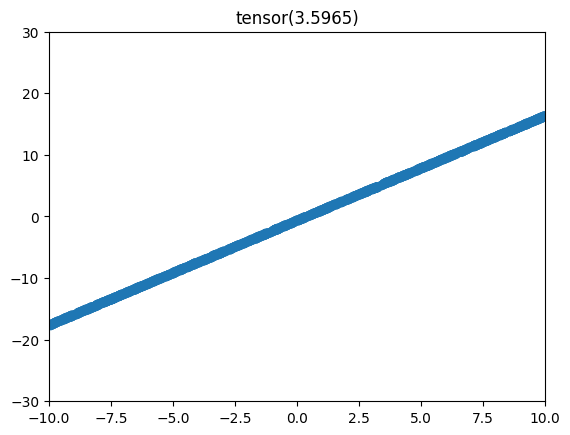

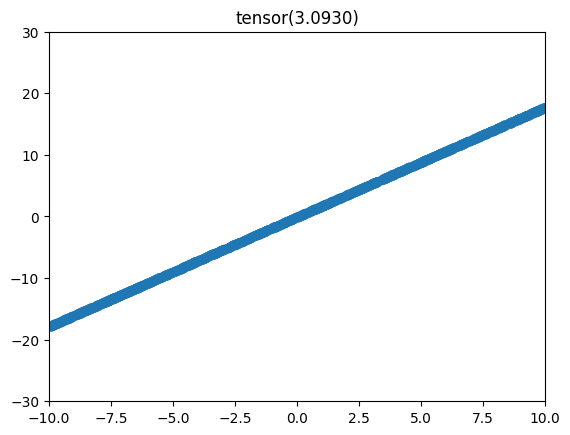

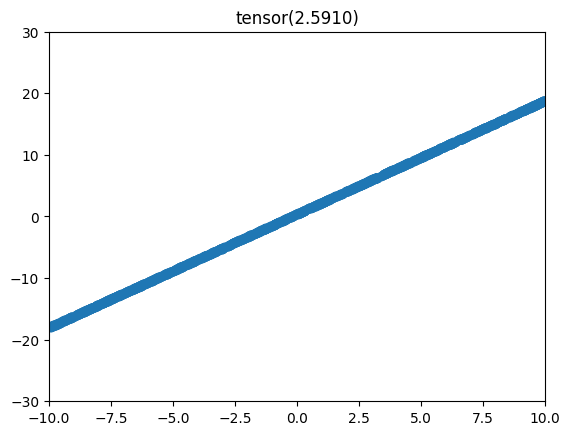

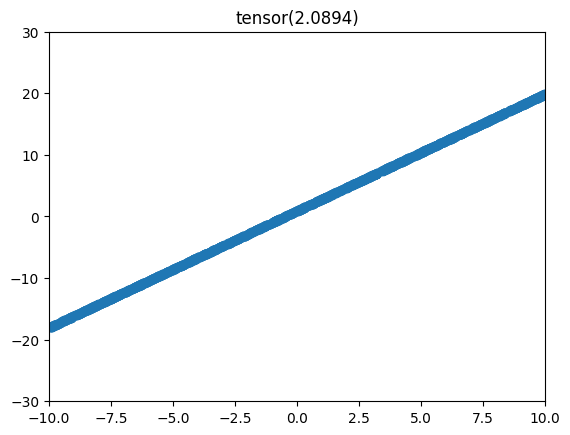

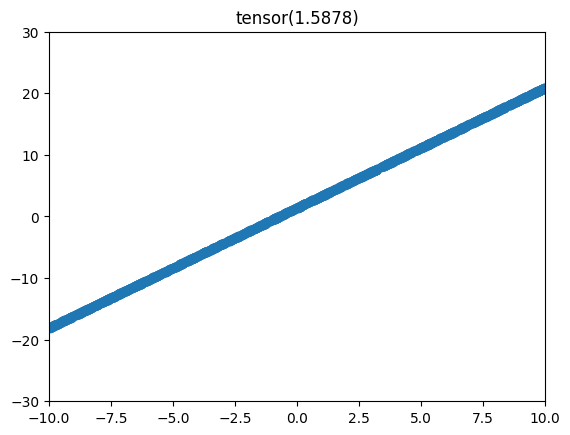

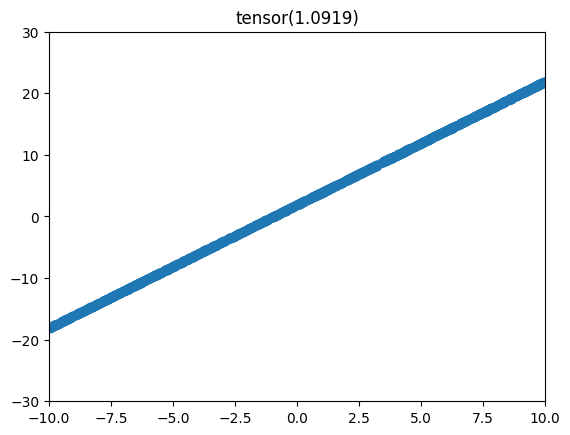

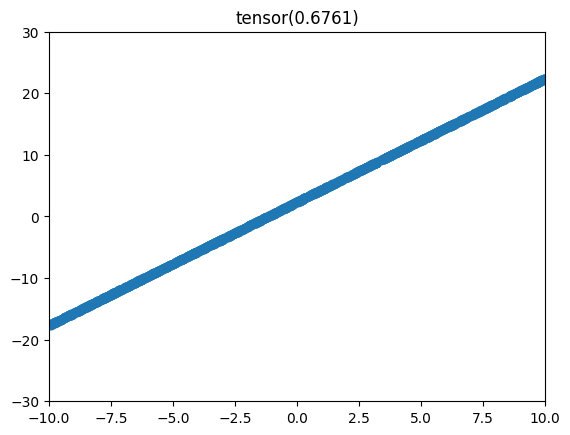

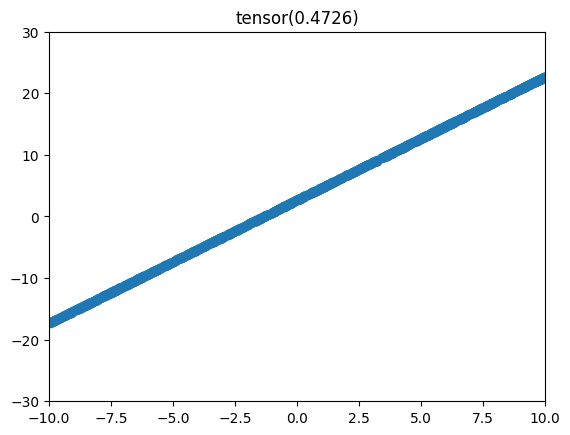

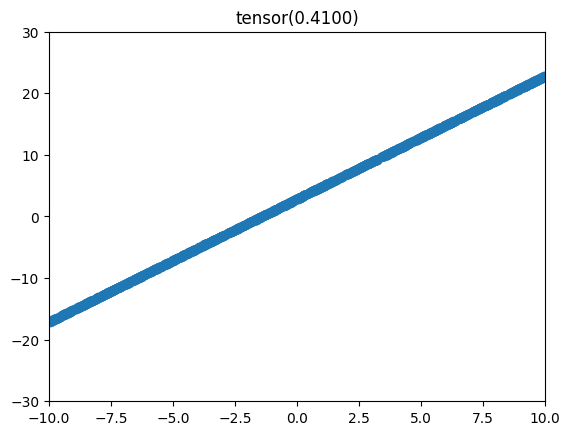

In [17]:
# 손실이 어떻게 변하는지 확인하기 위해 loss_arr를 만들어 기록합니다.
loss_arr =[]

# 또한 목표값은 y_noise로 지정해줍니다.
label = y_noise

# 500으로 지정했던 학습 횟수만큼 반복합니다.
for i in range(num_epoch):
  
    # 이전 학습의 기울기를 지우고 최적화 함수를 초기화해줍니다.
    # 기울기를 지우지 않으면 기존의 업데이트 때문에 학습이 잘 이루어지지 않습니다.
    optimizer.zero_grad()
    
    # 입력값 x를 모델에 넣어 결과값을 얻습니다.
    output = model(x)
    
    # 결과값과 목표값의 차이를 L1 손실 함수로 구해줍니다.
    loss = loss_func(output,label)
    
    # 손실에 대한 기울기를 구합니다.
    loss.backward()
    
    # 구한 기울기를 이용해 모델의 변수를 업데이트 합니다.
    optimizer.step()
    
    # 50번 마다 모델의 변수가 어떻게 변하고 있는지 출력해줍니다.
    if i % 50 == 0:
        # https://pytorch.org/docs/stable/tensors.html?highlight=detach#torch.Tensor.detach
        # 현재 연산 그래프에 속해있는 x, output 값을 detach를 통해 분리하고, 텐서를 넘파이 배열로 바꿔서 plt.scatter에 전달합니다.
        plt.title(loss.data)
        plt.scatter(x.detach().numpy(),output.detach().numpy())
        plt.axis([-10, 10, -30, 30])
        plt.show()
        
    # 손실을 loss_arr에 추가해줍니다.
    loss_arr.append(loss.detach().numpy())

### 3.4. 학습 결과 확인

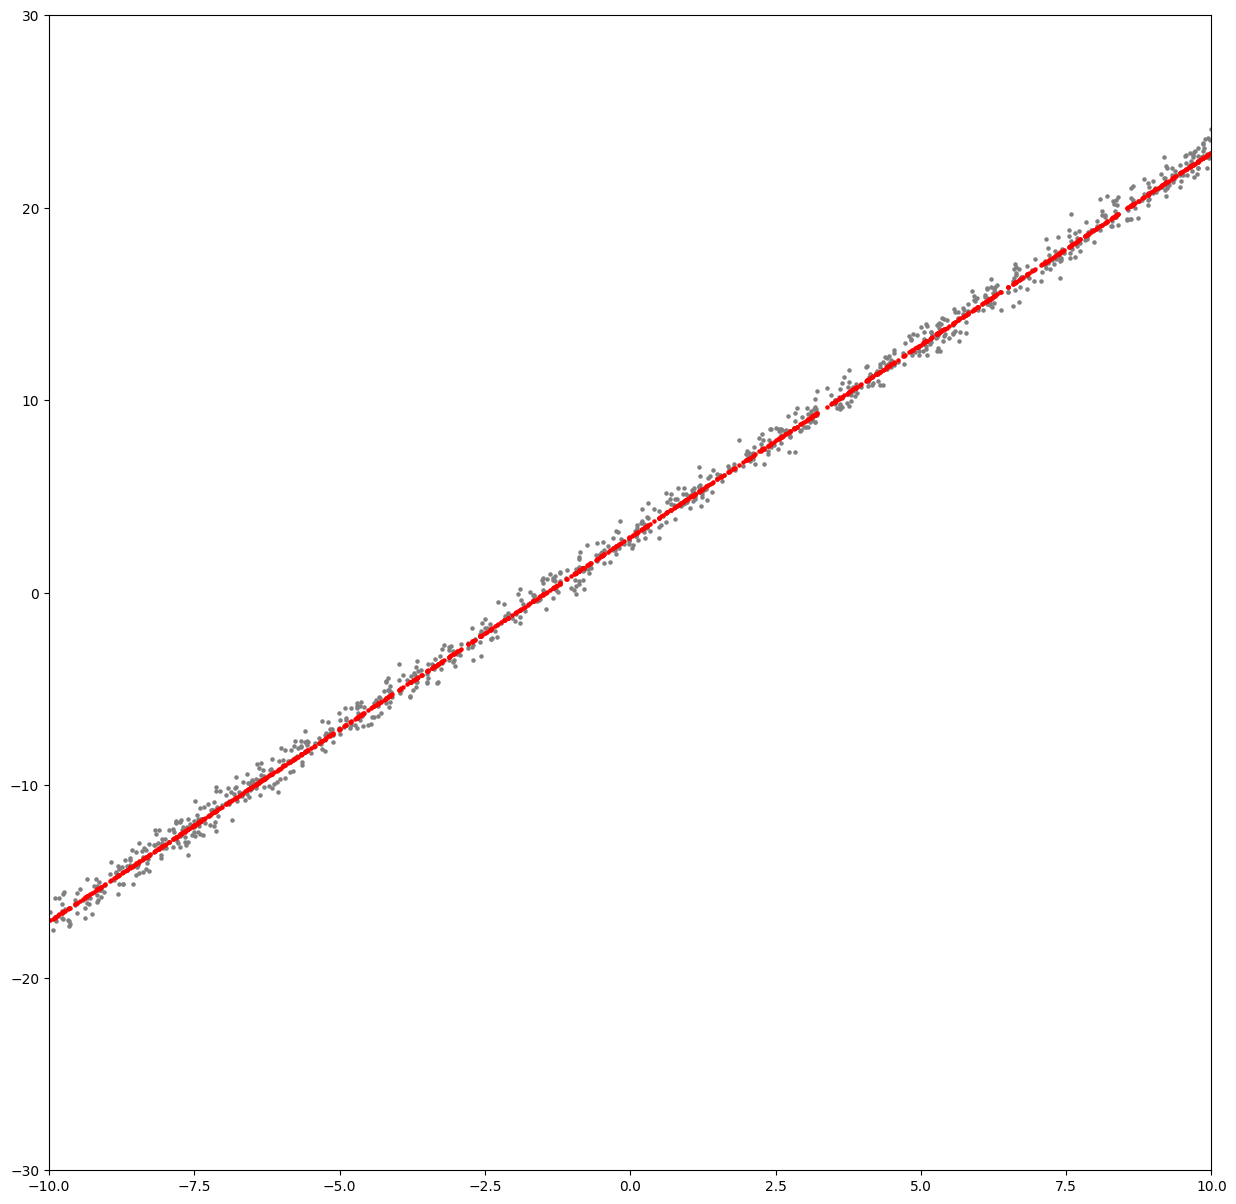

In [18]:
plt.figure(figsize=(15,15))
plt.scatter(x.numpy(),y_noise.numpy(),s=5,c="gray")
plt.scatter(x.detach().numpy(),output.detach().numpy(),s=5,c="red")
plt.axis([-10, 10, -30, 30])
plt.show()

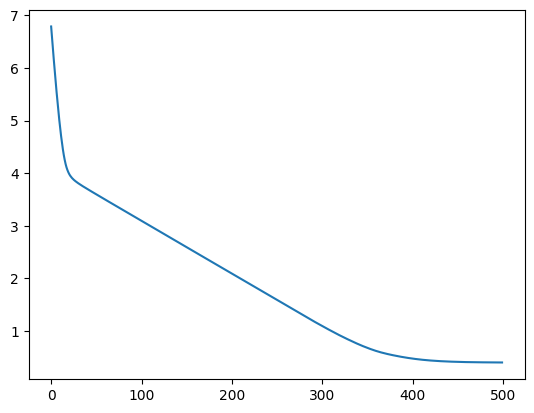

In [19]:
# matplotlib의 plot 함수를 이용해 손실이 어떻게 줄어가는지 확인합니다. 
plt.plot(loss_arr)
plt.show()

In [20]:
# 현재 모델은 weight와 bias을 변수로 가지고 있는데 그 값들이 학습 후 실제 몇인지 수치적으로 확인해봅니다.
param_list = list(model.parameters())
print("Weight:",param_list[0].item(),"\nBias:  ",param_list[1].item())

Weight: 1.996947169303894 
Bias:   2.907273530960083
